# FSV Mainz 05 Archive Data Explorer

This notebook provides interactive exploration of the comprehensive FSV Mainz 05 archive data.

## Contents:
1. Database Overview
2. Season Analysis
3. Player Statistics
4. Goal Analysis
5. Opponent Statistics
6. Historical Trends
7. Custom Queries

In [8]:
# Import libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Connect to database
conn = sqlite3.connect('fsv_archive_complete.db')

print("Database connected successfully!")
print("Available tables:")
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", conn)
for table in tables['name']:
    count = pd.read_sql(f"SELECT COUNT(*) as count FROM {table}", conn)['count'][0]
    print(f"  - {table}: {count:,} records")

Database connected successfully!
Available tables:
  - Seasons: 109 records
  - sqlite_sequence: 7 records
  - Opponents: 202 records
  - Matches: 2,774 records
  - Players: 8,136 records
  - Match_Lineups: 113,546 records
  - Goals: 6,288 records
  - Substitutions: 9,582 records


## 1. Database Overview

In [7]:
# Overall statistics
stats = {}
stats['Total Seasons'] = pd.read_sql("SELECT COUNT(*) FROM Seasons", conn).iloc[0,0]
stats['Total Matches'] = pd.read_sql("SELECT COUNT(*) FROM Matches", conn).iloc[0,0]
stats['Total Players'] = pd.read_sql("SELECT COUNT(*) FROM Players", conn).iloc[0,0]
stats['Total Goals'] = pd.read_sql("SELECT COUNT(*) FROM Goals", conn).iloc[0,0]
stats['Total Opponents'] = pd.read_sql("SELECT COUNT(*) FROM Opponents", conn).iloc[0,0]

# Win/Draw/Loss statistics
results = pd.read_sql("""
    SELECT 
        SUM(CASE WHEN mainz_goals > opponent_goals THEN 1 ELSE 0 END) as Wins,
        SUM(CASE WHEN mainz_goals = opponent_goals THEN 1 ELSE 0 END) as Draws,
        SUM(CASE WHEN mainz_goals < opponent_goals THEN 1 ELSE 0 END) as Losses,
        SUM(mainz_goals) as Goals_For,
        SUM(opponent_goals) as Goals_Against
    FROM Matches
""", conn)

print("=" * 60)
print("FSV MAINZ 05 - ALL-TIME STATISTICS")
print("=" * 60)
for key, value in stats.items():
    print(f"{key:20}: {value:,}")
print("\nAll-Time Record:")
print(f"  Wins:   {results['Wins'][0]:,} ({results['Wins'][0]/stats['Total Matches']*100:.1f}%)")
print(f"  Draws:  {results['Draws'][0]:,} ({results['Draws'][0]/stats['Total Matches']*100:.1f}%)")
print(f"  Losses: {results['Losses'][0]:,} ({results['Losses'][0]/stats['Total Matches']*100:.1f}%)")
print(f"\nGoals:")
print(f"  Scored:   {results['Goals_For'][0]:,}")
print(f"  Conceded: {results['Goals_Against'][0]:,}")
print(f"  Difference: {results['Goals_For'][0] - results['Goals_Against'][0]:+,}")

DatabaseError: Execution failed on sql 'SELECT COUNT(*) FROM Seasons': no such table: Seasons

## 2. Season Analysis

In [7]:
# Seasons overview
seasons_df = pd.read_sql("""
    SELECT 
        s.season_name,
        s.league_name,
        s.total_matches,
        SUM(CASE WHEN m.mainz_goals > m.opponent_goals THEN 1 ELSE 0 END) as Wins,
        SUM(CASE WHEN m.mainz_goals = m.opponent_goals THEN 1 ELSE 0 END) as Draws,
        SUM(CASE WHEN m.mainz_goals < m.opponent_goals THEN 1 ELSE 0 END) as Losses,
        SUM(m.mainz_goals) as Goals_For,
        SUM(m.opponent_goals) as Goals_Against,
        SUM(CASE WHEN m.mainz_goals > m.opponent_goals THEN 3 
            WHEN m.mainz_goals = m.opponent_goals THEN 1 
            ELSE 0 END) as Points
    FROM Seasons s
    LEFT JOIN Matches m ON s.season_id = m.season_id
    WHERE s.total_matches > 0
    GROUP BY s.season_id
    ORDER BY s.season_name DESC
""", conn)

print("Recent Seasons (Last 10):")
print("="*100)
display(seasons_df.head(10))

# Best seasons by points per game
seasons_df['PPG'] = seasons_df['Points'] / seasons_df['total_matches']
seasons_df['GD'] = seasons_df['Goals_For'] - seasons_df['Goals_Against']

print("\nBest Seasons by Points Per Game:")
print("="*80)
best_seasons = seasons_df.nlargest(10, 'PPG')[['season_name', 'league_name', 'Wins', 'Draws', 'Losses', 'GD', 'PPG']]
display(best_seasons)

Recent Seasons (Last 10):


,season_name,league_name,total_matches,Wins,Draws,Losses,Goals_For,Goals_Against,Points
0,2024-25,Bundesliga,34,14,10,10,55,43,52
1,2023-24,Bundesliga,34,7,14,13,39,51,35
2,2022-23,Bundesliga,34,12,10,12,54,55,46
3,2021-22,Bundesliga,34,13,7,14,50,45,46
4,2020-21,Bundesliga,34,10,9,15,39,56,39
5,2019-20,Bundesliga,34,11,4,19,44,65,37
6,2018-19,Bundesliga,34,12,7,15,46,57,43
7,2017-18,Bundesliga,34,9,9,16,38,52,36
8,2016-17,Bundesliga,34,10,7,17,44,55,37
9,2015-16,Bundesliga,34,14,8,12,46,42,50



Best Seasons by Points Per Game:


,season_name,league_name,Wins,Draws,Losses,GD,PPG
35,1989-90,Amateur-Oberliga Südwest,29,4,1,75,2.676471
82,1932-33,Bezirksliga Hessen,14,3,1,37,2.500000
83,1931-32,Bezirksliga Hessen,14,1,3,43,2.388889
80,1934-35,Bezirksklasse Rheinhessen,16,3,3,43,2.318182
86,1928-29,Bezirksliga Hessen,12,0,4,29,2.250000
89,1925-26,Bezirksliga Rheinhessen-Saar,10,1,3,11,2.214286
43,1980-81,Amateur-Oberliga Südwest,23,5,6,45,2.176471
37,1987-88,Amateur-Oberliga Südwest,21,10,3,37,2.147059
88,1926-27,Bezirksliga Rheinhessen-Saar,12,2,4,23,2.111111
50,1972-73,Regionalliga Südwest,18,8,4,39,2.066667


In [8]:
# Select a specific season for detailed view
season_to_view = '2023-24'  # Change this to explore different seasons

matches_df = pd.read_sql(f"""
    SELECT 
        m.gameday as Matchday,
        CASE WHEN m.is_home_game THEN 'H' ELSE 'A' END as H_A,
        o.opponent_name as Opponent,
        m.mainz_goals || ':' || m.opponent_goals as Result,
        CASE 
            WHEN m.mainz_goals > m.opponent_goals THEN 'W'
            WHEN m.mainz_goals = m.opponent_goals THEN 'D'
            ELSE 'L'
        END as W_D_L
    FROM Matches m
    JOIN Seasons s ON m.season_id = s.season_id
    JOIN Opponents o ON m.opponent_id = o.opponent_id
    WHERE s.season_name = '{season_to_view}'
    ORDER BY m.gameday
""", conn)

print(f"Season {season_to_view} - All Matches:")
print("="*60)
display(matches_df)

Season 2023-24 - All Matches:


,Matchday,H_A,Opponent,Result,W_D_L
0,1,A,1. FC Union Berlin,1:4,L
1,2,H,SG Eintracht Frankfurt,1:1,D
2,3,A,SV Werder Bremen,0:4,L
3,4,H,VfB Stuttgart,1:3,L
4,5,A,FC Augsburg,1:2,L
5,6,H,Bayer 04 Leverkusen,0:3,L
6,7,A,Borussia Mönchengladbach,2:2,D
7,8,H,FC Bayern München,1:3,L
8,9,A,VfL Bochum,2:2,D
9,10,H,Rasenballsport Leipzig,2:0,W


## 3. Player Statistics

In [9]:
# Top scorers all-time
top_scorers = pd.read_sql("""
    SELECT 
        p.player_name as Player,
        COUNT(g.goal_id) as Goals,
        MIN(s.season_name) as First_Season,
        MAX(s.season_name) as Last_Season,
        COUNT(DISTINCT s.season_id) as Seasons_Played
    FROM Goals g
    JOIN Players p ON g.player_id = p.player_id
    JOIN Matches m ON g.match_id = m.match_id
    JOIN Seasons s ON m.season_id = s.season_id
    GROUP BY p.player_id
    ORDER BY Goals DESC
    LIMIT 25
""", conn)

print("Top 25 All-Time Goal Scorers:")
print("="*80)
display(top_scorers)

Top 25 All-Time Goal Scorers:


,Player,Goals,First_Season,Last_Season,Seasons_Played
0,Bopp,100,1967-68,1984-85,10
1,Mähn,86,1979-80,1989-90,9
2,Klier,79,1971-72,1976-77,6
3,Müller,66,1929-30,2009-10,31
4,Burkardt,53,2019-20,2024-25,6
5,Fuchs,50,1935-36,1988-89,7
6,C. Tripp,46,1964-65,1967-68,4
7,Demandt,46,1988-89,2000-01,9
8,Scheller,45,1970-71,1985-86,10
9,Klopp,44,1990-91,1999-00,10


In [10]:
# Most appearances
appearances = pd.read_sql("""
    SELECT 
        p.player_name as Player,
        COUNT(DISTINCT ml.match_id) as Appearances,
        COUNT(DISTINCT CASE WHEN ml.is_starter THEN ml.match_id END) as Starts,
        COUNT(DISTINCT CASE WHEN ml.is_captain THEN ml.match_id END) as As_Captain,
        MIN(s.season_name) as First_Season,
        MAX(s.season_name) as Last_Season
    FROM Match_Lineups ml
    JOIN Players p ON ml.player_id = p.player_id
    JOIN Matches m ON ml.match_id = m.match_id
    JOIN Seasons s ON m.season_id = s.season_id
    GROUP BY p.player_id
    ORDER BY Appearances DESC
    LIMIT 25
""", conn)

print("Top 25 Players by Appearances:")
print("="*80)
display(appearances)

Top 25 Players by Appearances:


,Player,Appearances,Starts,As_Captain,First_Season,Last_Season
0,Müller,452,452,0,1929-30,2021-22
1,Wache,381,381,0,1995-96,2008-09
2,Bell,375,375,1,1982-83,2024-25
3,Klopp,332,332,0,1990-91,2003-04
4,Wetklo,329,329,0,2000-01,2014-15
5,Noveski,327,327,0,2003-04,2014-15
6,Janz,323,323,0,1970-71,1995-96
7,Mähn,315,315,0,1979-80,1990-91
8,Neustädter,303,303,0,1993-94,2015-16
9,Müllges,300,300,0,1959-60,1970-71


## 4. Goal Analysis

Goals by Time Period:


,Time_Period,Goals
0,0-15,1077
1,16-30,1229
2,31-45,1186
3,46-60,900
4,61-75,944
5,76-90,945
6,90+,7


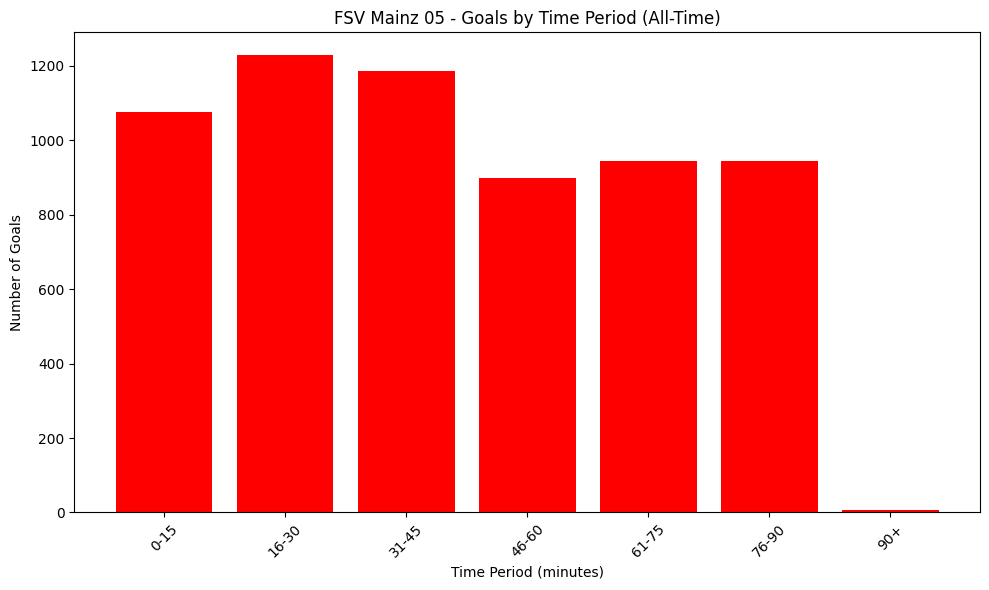

In [9]:
# Goals by minute
goals_by_minute = pd.read_sql("""
    SELECT 
        CASE 
            WHEN goal_minute <= 15 THEN '0-15'
            WHEN goal_minute <= 30 THEN '16-30'
            WHEN goal_minute <= 45 THEN '31-45'
            WHEN goal_minute <= 60 THEN '46-60'
            WHEN goal_minute <= 75 THEN '61-75'
            WHEN goal_minute <= 90 THEN '76-90'
            ELSE '90+'
        END as Time_Period,
        COUNT(*) as Goals
    FROM Goals
    WHERE goal_minute IS NOT NULL
    GROUP BY Time_Period
    ORDER BY 
        CASE Time_Period
            WHEN '0-15' THEN 1
            WHEN '16-30' THEN 2
            WHEN '31-45' THEN 3
            WHEN '46-60' THEN 4
            WHEN '61-75' THEN 5
            WHEN '76-90' THEN 6
            ELSE 7
        END
""", conn)

print("Goals by Time Period:")
print("="*40)
display(goals_by_minute)

# Plot goals by minute
plt.figure(figsize=(10, 6))
plt.bar(goals_by_minute['Time_Period'], goals_by_minute['Goals'], color='red')
plt.xlabel('Time Period (minutes)')
plt.ylabel('Number of Goals')
plt.title('FSV Mainz 05 - Goals by Time Period (All-Time)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Opponent Statistics

In [10]:
# Head-to-head with specific opponent
opponent = 'FC Bayern München'  # Change this to analyze different opponents

h2h_matches = pd.read_sql(f"""
    SELECT 
        s.season_name as Season,
        CASE WHEN m.is_home_game THEN 'Home' ELSE 'Away' END as Venue,
        m.mainz_goals || ':' || m.opponent_goals as Result,
        CASE 
            WHEN m.mainz_goals > m.opponent_goals THEN 'Win'
            WHEN m.mainz_goals = m.opponent_goals THEN 'Draw'
            ELSE 'Loss'
        END as Outcome
    FROM Matches m
    JOIN Opponents o ON m.opponent_id = o.opponent_id
    JOIN Seasons s ON m.season_id = s.season_id
    WHERE o.opponent_name = '{opponent}'
    ORDER BY s.season_name DESC
""", conn)

if not h2h_matches.empty:
    print(f"Head-to-Head vs {opponent}:")
    print("="*60)
    summary = h2h_matches['Outcome'].value_counts()
    print(f"Total Games: {len(h2h_matches)}")
    print(f"Wins: {summary.get('Win', 0)}")
    print(f"Draws: {summary.get('Draw', 0)}")
    print(f"Losses: {summary.get('Loss', 0)}")
    print(f"\nAll Matches:")
    display(h2h_matches)
else:
    print(f"No matches found against {opponent}")

Head-to-Head vs FC Bayern München:
Total Games: 38
Wins: 8
Draws: 3
Losses: 27

All Matches:


,Season,Venue,Result,Outcome
0,2024-25,Home,2:1,Win
1,2024-25,Away,0:3,Loss
2,2023-24,Home,1:3,Loss
3,2023-24,Away,1:8,Loss
4,2022-23,Away,2:6,Loss
5,2022-23,Home,3:1,Win
6,2021-22,Away,1:2,Loss
7,2021-22,Home,3:1,Win
8,2020-21,Away,2:5,Loss
9,2020-21,Home,2:1,Win


## 6. Custom Queries

Use this section to run your own SQL queries on the database.

In [ ]:
# Example: Find all matches with a specific scoreline
scoreline = '5:0'  # Change this to search for different results
home_goals, away_goals = scoreline.split(':')

big_wins = pd.read_sql(f"""
    SELECT 
        s.season_name as Season,
        o.opponent_name as Opponent,
        CASE WHEN m.is_home_game THEN 'Home' ELSE 'Away' END as Venue,
        m.mainz_goals || ':' || m.opponent_goals as Result
    FROM Matches m
    JOIN Seasons s ON m.season_id = s.season_id
    JOIN Opponents o ON m.opponent_id = o.opponent_id
    WHERE m.mainz_goals = {home_goals} AND m.opponent_goals = {away_goals}
    ORDER BY s.season_name DESC
""", conn)

print(f"All {scoreline} victories:")
print("="*60)
if not big_wins.empty:
    display(big_wins)
else:
    print(f"No matches found with scoreline {scoreline}")

In [ ]:
# Close the database connection
conn.close()
print("Database connection closed.")